### Simple Example for Fitting a Hidden Markov Model (HMM) 

This notebook is designed to help users get started using the glm-hmm package to fit HMMs to their data. Here we use simulated data so that we can check that we are inferring the correct model parameters, but the same fitting procedure applies when using real experimental data. All the same general ideas (code structure and parameter validation) also apply when fitting GLM-HMMs. For more details on that model, see the fit-glm-hmm.ipynb notebook. 

#### 1. Import the required code packages and modules.

In [1]:
import sys
sys.path.append("/Users/irisstone/Google Drive (istone@princeton.edu)/Princeton/Research/Striatum Towers Task/code/glmhmm")
import matplotlib.pyplot as plt
import numpy as np
import time
from glmhmm import hmm
from glmhmm.utils import permute_states, find_best_fit
from glmhmm.visualize import plot_model_params

#### 2. Set the hyper-parameters of the HMM

In [2]:
N = 10000 # number of data/time points
K = 2 # number of latent states
C = 2 # number of observation classes

#### 3. Instantiate the model and generate true parameters

The parameters of an HMM include the transition probabilities $A$, the observation (or emission) probabilities $\phi$, and the initial state probabilities $\pi$.

In [3]:
true_HMM = hmm.HMM(N,0,C,K)
A_true,phi_true,pi_true = true_HMM.generate_params()

#### 4. Given the true parameters, generate some data. 

The data include the observations $y$ and the latent states $z$ at each time point. 

In [4]:
true_y,true_z = true_HMM.generate_data(A_true,phi_true)

#### 5. Fit the model

The fitting code uses the expectation maximization (EM) algorithm to infer the model parameters. Because EM does not guarantee that it will find the best fit (global optimum) and inference is often dependent on the choice of parameter initialization, it is often best to fit the model multiple times using different initializations and then select the best one based on which fit obtained the highest log-likelihood. <b>Note:</b> For this example, we are not inferring the initial state probabilities, but instead assuming a uniform distribution over the initial states.

In [5]:
inits = 2 # set the number of initializations

# store values for each initialization
lls_all = np.zeros((inits,250))
A_all = np.zeros((inits,K,K))
phi_all = np.zeros((inits,K,C))

# fit the model for each initialization
for i in range(inits):
    A_init,phi_init,pi_init = true_HMM.generate_params() # initialize the model parameters
    lls_all[i,:],A_all[i,:,:],phi_all[i,:,:],pi0 = true_HMM.fit(true_y,A_init,phi_init) # fit the model
    print('initialization %s complete' %(i+1))

initialization 1 complete
initialization 2 complete


#### 6. Compare the inferred model parameters for the best fit to the true parameter values.

Text(0.5, 1.0, 'Inferred $\\phi$')

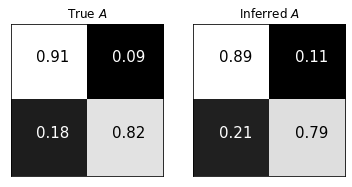

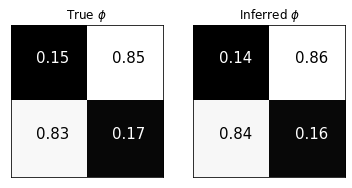

In [9]:
bestix = find_best_fit(lls_all) # find the initialization that led to the best fit

# for easy comparison permute the states in order from highest to lowest self-transition probability
A_permuted, order = permute_states(A_all[bestix])
A_true_permuted, order_true = permute_states(A_true)

# plot the true vs. inferred transition probabilities
fig, ax = plt.subplots(1,2,sharey=True)
    
plot_model_params(A_true_permuted,ax[0])
plot_model_params(A_permuted, ax[1])

ax[0].set_title('True $A$')
ax[1].set_title('Inferred $A$')

# permute the observation probability matrices according to the above order
phi_permuted,_ = permute_states(phi_all[bestix],method='order',param='observations',order=order)
phi_true_permuted,_ = permute_states(phi_true,method='order',param='observations',order=order_true)

# plot the true vs. inferred observation probabilities
fig, ax = plt.subplots(1,2,sharey=True)
    
plot_model_params(phi_true_permuted,ax[0])
plot_model_params(phi_permuted, ax[1])

ax[0].set_title('True $\phi$')
ax[1].set_title('Inferred $\phi$')

#### 7. Cross validation can further assess model performance.

In [20]:

true_ll,_,_ = true_HMM.forwardPass(true_y,A_true,phi_true,pi0=None)
fit_ll,_,_ = true_HMM.forwardPass(true_y,A_all[bestix],phi_all[bestix])

# compare loglikelihoods
print('True LL: %f' %(true_ll))
print('Inferred LL: %f' %(fit_ll))

True LL: -6906.931493
Inferred LL: -6906.292260


Text(0, 0.5, 'loglikelihood')

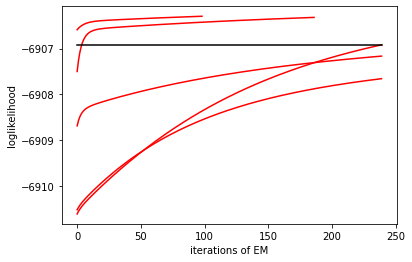

In [19]:
plt.plot(lls_all.T[10:],color='red')
plt.plot(np.ones(240)*true_ll,color='black')
plt.xlabel('iterations of EM')
plt.ylabel('loglikelihood')